# Compute IP/EA with XTB
Check on how the calculations are doing. What the run times are, what fractions have completed, etc.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from edw.qc import GeometryDataset, SolvationEnergyDataset, compute_ionization_potentials, f
from qcelemental.physical_constants import constants
import pandas as pd
import numpy as np

## Get the Geometries
Gather the XTB geometries

In [2]:
dataset = GeometryDataset('Electrolyte Geometry XTB', 'xtb')

Print out the general statusqcelemental

In [3]:
dataset.coll.status()

,xtb
COMPLETE,4503
ERROR,1


Review the completed geometries

In [4]:
%%time
geoms = dataset.get_geometries()
print(f'Completed {sum(map(len, geoms.values()))} geometries of {len(geoms)} molecules')
print(f'All ionic states computed for {len(list(filter(lambda x: len(x) == 3, geoms.values())))} molecules')

Completed 4503 geometries of 1501 molecules
All ionic states computed for 1501 molecules
CPU times: user 2.1 s, sys: 44.8 ms, total: 2.15 s
Wall time: 5.51 s


## Review the Solvation Energy Calculations
Compute the solvation energies for all of the molecules

In [5]:
solv_dataset = SolvationEnergyDataset('EDW XTB Solvation Energy', 'xtb', 'xtb')

Pull down a summary

In [6]:
%%time
solv_energies = solv_dataset.get_energies()
solv_df = solv_dataset.coll.get_values()
print(f'Completed {(~solv_df.isnull()).values.sum()} solvation energies '
      f'of {len(solv_energies)} molecules')

Completed 17863 solvation energies of 1592 molecules
CPU times: user 5.85 s, sys: 35.7 ms, total: 5.88 s
Wall time: 22.4 s


In [7]:
redox_data = compute_ionization_potentials(dataset, solv_dataset)

### Compute Redox Properties from Gaussian
We have the raw energies, will have to do some work to process them into a usable form

In [8]:
gaussian_data = pd.read_csv('solvent_results-3.csv')

In [12]:
def compute_ea_ip(level='b3lyp'):
    # Compute the EA and IP in each solvent we have
    for label, name in zip(['reduced', 'oxidized'], ['EA', 'IP']):
        # Prefactor
        p = -1 if name == "EA" else 1

        # Compute the potential in gas
        g_chg = gaussian_data[f'u0_{label}.{level}'] - gaussian_data[f'u0.{level}']
        g_chg_u = constants.ureg.Quantity(g_chg.values * constants.hartree2kcalmol, 'kcal/mol')
        gaussian_data[name] = (p * g_chg_u / f).to("V").magnitude

        # Correct for solvent
        sol_cols = ['water', 'acetonitrile', 'ethanol', 'dimethylsulfoxide', 'acetone']
        for solv in sol_cols:

            solv_neu = gaussian_data[f'solvent_neutral.B3LYP_{solv}'] / constants.hartree2kcalmol
            solv_chg = gaussian_data[f'solvent_{label}.B3LYP_{solv}'] - (gaussian_data[f'u0_{label}.b3lyp'] - gaussian_data[f'zpe_{label}.b3lyp'])
            g_solv = constants.ureg.Quantity(
                (g_chg + solv_chg - solv_neu).values * constants.hartree2kcalmol, 'kcal/mol')
            e_red = p * g_solv / (1 * f)
            gaussian_data[f'{name}_{solv}'] = e_red.to("V").magnitude
compute_ea_ip('b3lyp')

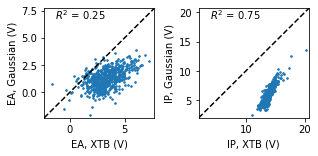

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(4.5, 2.25))

merged_data = redox_data.merge(gaussian_data, on='inchi_key', suffixes=['_xtb', '_g09'])

for l, ax in zip(['EA', 'IP'], axs):
    xtb = merged_data[f'{l}_xtb']
    g09 = merged_data[f'{l}_g09']
    r2 = np.corrcoef(xtb, g09)[0, 1] ** 2
    ax.scatter(xtb, g09, s=2.5)
    ax.text(0.1, 0.9, f'$R^2$ = {r2:.2f}', transform=ax.transAxes)

    min_ = min(ax.get_xlim()[0], ax.get_ylim()[0])
    max_ = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim(min_, max_)
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

    ax.set_xlabel(f'{l}, XTB (V)')
    ax.set_ylabel(f'{l}, Gaussian (V)')
fig.tight_layout()

Save the Gaussian Data

In [11]:
gaussian_data.to_csv('gaussian-redox.csv', index=False)

**TODO**: Send XTB results to 

In [ ]:
redox_data.